# Time series Forecasting

#### Importing libraries for time series forecasting

In [72]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from fbprophet import Prophet

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

## Data import, summary and preprocessing
- Dataset: International airline passengers
- Unit: Thousands

In [2]:
df = pd.read_csv('international-airline-passengers.csv')
df.columns = ['year','passengers']

df.head(10)

,year,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [3]:
df.dtypes

year          object
passengers     int64
dtype: object

In [4]:
df.describe()

,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [5]:
df.describe(include='O')

,year
count,144
unique,144
top,1949-01
freq,1


In [6]:
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))

Time period start: 1949-01
Time period end: 1960-12


In [7]:
df.shape

(144, 2)

__Converting to datetime format:__

In [9]:
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

__Setting index as the datetime column for easier manipulations:__

In [10]:
y = df.set_index('year')

In [11]:
y.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], dtype='datetime64[ns]', name='year', length=144, freq=None)

In [12]:
y.isnull().sum()

passengers    0
dtype: int64

Forecast evaluation function

In [13]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

**A key requirement for ARIMA models is stationarity of time series**

A time series is stationary if its mean and variance are constant over time

Check stationarity of time series using:

- Time series plots
- Moving averages or variances
- Dickey-Fuller test
- ACF and PACF plots

####  Time series plots

A visual observation of time series plots / histograms can give an insight into the presence of trend and seasonality in the data

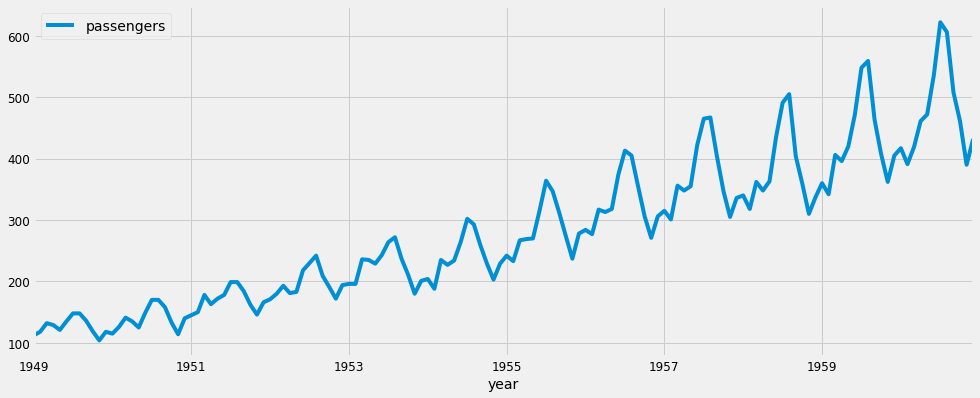

In [14]:
y.plot(figsize=(15, 6))
plt.show()

__Reviewing plots of the density of observations can provide further insight into the structure of the data:__
- The distribution is not perfectly Gaussian (normal distribution).
- The distribution is left shifted.
- Transformations might be useful prior to modeling.

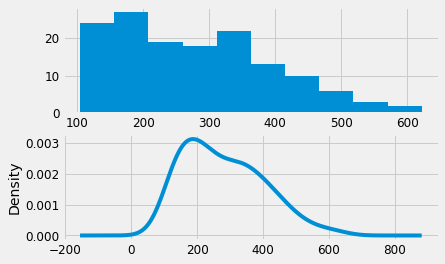

In [15]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.passengers.hist()
pyplot.subplot(212)
y.passengers.plot(kind='kde')
pyplot.show()

### Box and Whisker Plots:

<AxesSubplot:xlabel='year', ylabel='passengers'>

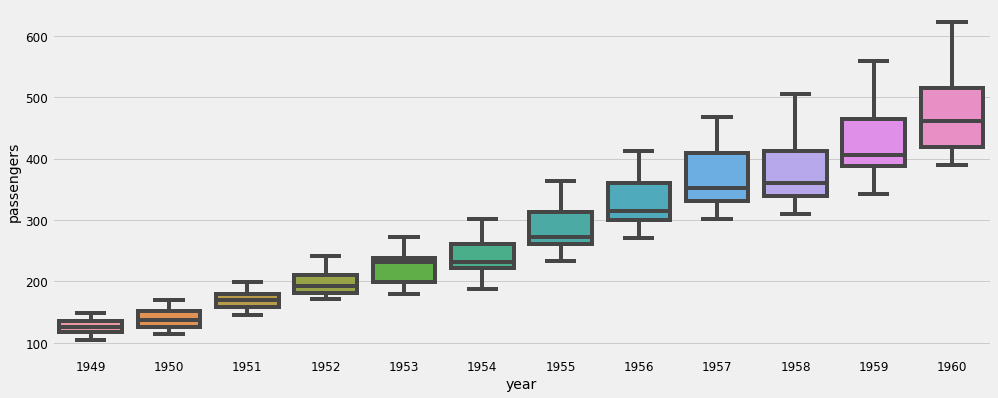

In [16]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(y.passengers.index.year, y.passengers, ax=ax)

* Median values across years confirms an upwards trend
* Steady increase in the spread, or middle 50% of the data (boxes) over time
* A model considering seasonality might work well


### Plotting rolling statistics

One can plot moving averages/variances to observe any changes in the average/variance over time.

The data can be partitioned into various subsets of different time intervals and summary statistics such as mean and variances can be observed over these time periods



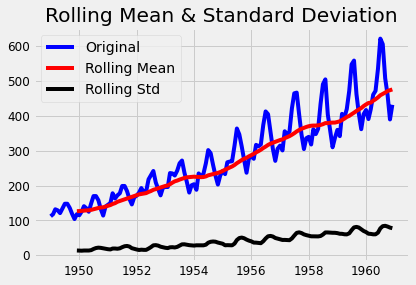

In [17]:
#Determing rolling statistics

rolmean = y.rolling(window=12).mean()
rolstd = y.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(y, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

- We observe that the rolling mean and Standard deviation are not constant with respect to time (increasing trend)
- The time series is hence not stationary

### Augmented Dickey- Fuller test

The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1) will provide no relevant information in predicting the change in y(t).

- Null Hypothesis (H0) that the time series is not stationary and 
- Alternate hypothesis (H1) that the time series is stationary. 

The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the 'Test Statistic' is less than the 'Critical Value', we can reject the null hypothesis and say that the series is stationary.


In [18]:
#Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.passengers, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


We do not reject the null hypothesis that the time series is not stationary at p value of 0.99.

### ACF and PACF plots

**ACF (Autocorrelation function)** : 
     ACF plot is a bar chart of the coefficients of correlation between a time series and lags of itself
       
**PACF (Partial Autocorrelation function)** : 
    'Partial' autocorrelation between two variables is the amount of correlation between the variables that is not explained by their mutual correlations with a specified set of other variables.
    
For example, if we are regressing a variable Y on other variables X1, X2, and X3, the partial correlation between Y and X3 is the amount of correlation between Y and X3 that is not explained by their common correlations with X1 and X2. This partial correlation can be computed as the square root of the reduction in variance that is achieved by adding X3 to the regression of Y on X1 and X2.

In [20]:
ts = y.passengers
ts.dropna(inplace=True)

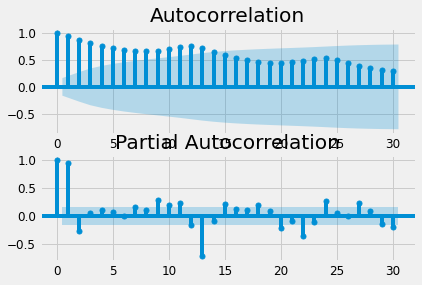

In [21]:
# plot ACF & PACF charts
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(),lags=30)
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca(),lags=30)
pyplot.show()

* If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points
* This data is non-stationary as a high number of previous observations are correlated with future values
* Confidence intervals are drawn as a cone
* By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke
* The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags

There are two major reasons why a time series is non-stationarity:

1. __Trend__ – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. __Seasonality__ – variations at specific time-frames. eg people might have a tendency to travel in a particular month because of holiday.

### Function to test stationarity

In [22]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

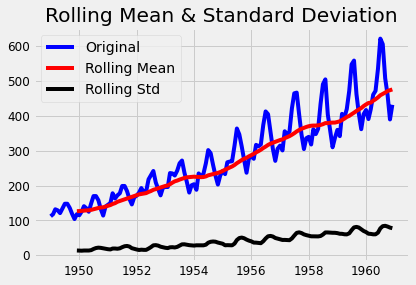

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [23]:
test_stationarity(ts)

#### Making a time series stationary

Most of the real life datasets will exhibit non stationarity.

There are multiple ways to make a time series stationary:

- Transformation
    - Log transformation
    - Square root transformation
    - Box cox transformation
    - Exponential transformation


- Differencing: Differencing is carried out to get rid of varying mean due to trend. In this difference in consecutive terms in the time series is computed. Mathematically it can be represented as :
                  yt = yt - y(t-1)
                  where yt is the value at time t.
    - Seasonal differencing: In case of presence of seasonality in the data, seasonal differencing can be carried out. In seasonal differencing, we calculate the difference between observation and previous observation of the same season. For example, an observation taken on a Monday is subtracted from that taken on previous Monday or that taken for week1 of a month is subtracted from week  of the previous month. Mathematically it can be represented as:
    
                   yt‘ = yt – y(t-n) 
                   where n is the season length
- Smoothing
- Decomposition


### Transformations

#### Log scale transformation

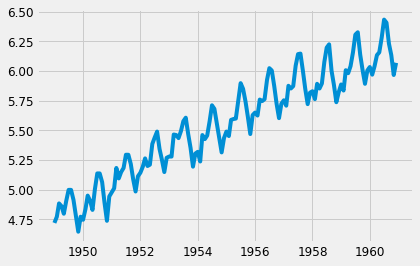

In [24]:
ts_log = np.log(y.passengers)
plt.plot(ts_log)

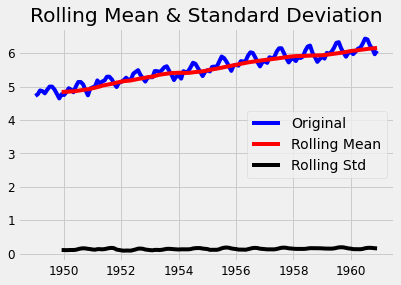

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [25]:
ts_log.dropna(inplace=True)
test_stationarity(ts_log)

Since p value id 0.42, also mean is not constant, hence the log scale transformation is not making the series stationary. 

#### Differencing
In this technique, we take the difference of the observation at a particular instant with that at the previous instant. 

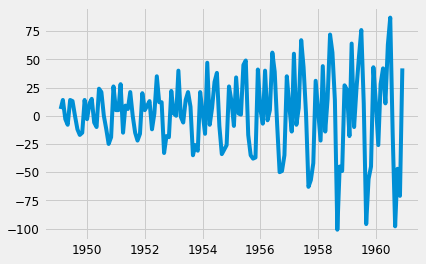

In [26]:
ts_diff = ts - ts.shift()
plt.plot(ts_diff)

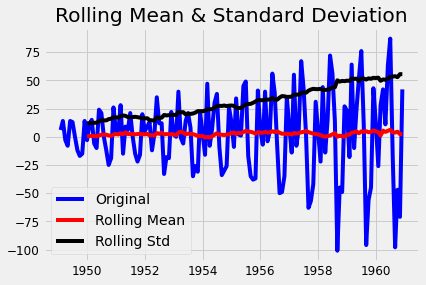

Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [27]:
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

Here, the p value after Dickey - Fuller test is 0.05 which says that the series is stationatry but from the graph we can see that the standard deviation is not constant.

### Log Diffrencing

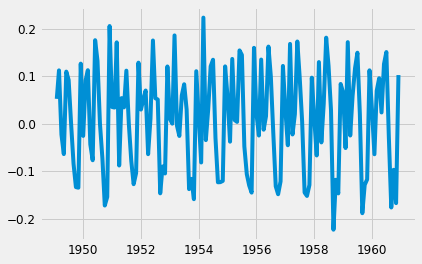

In [28]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

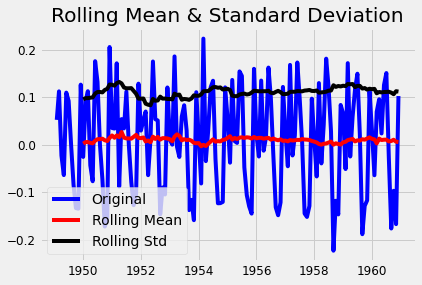

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [29]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

At p value 0.07 we reject the null hypothesis that the time series is not statinoary. i.e. the time series is stationary

###  Exponentially weighted moving average:
- To overcome the problem of choosing a defined window in moving average and to give higher importance to recent readings, a weighted moving average can be used
- We take a 'weighted moving average' where more recent values are given a higher weight. 
- There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor. 



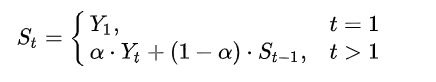
- Here, the coefficient α represents the degree of weighing decrease, a constant factor between 0 and 1. Higher α discounts older observations faster.
- Yt is value of the time series at time t
- St is the value of the EMA at any time period t.

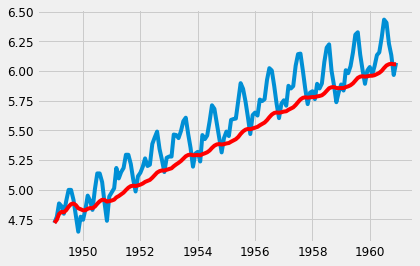

In [30]:
expwighted_avg = ts_log.ewm(halflife = 12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

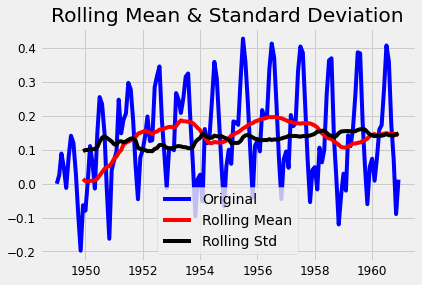

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [31]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

### Decomposition

In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned.

Decomposition method breaks a time series into following components:

- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series. 
- Seasonality: The repeating short-term cycle in the series
- Noise: The random variation in the series.



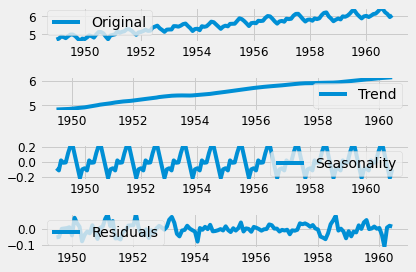

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
# plt.tight_layout(pad=3.0)

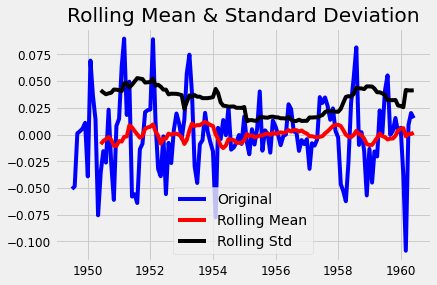

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [33]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

The series of residuals is stationary

## ARIMA Models

An ARIMA (AutoRegressive Integrated Moving Average) model is a class of statistical models for analyzing and forecasting time series data.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

- __AR__: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- __I__: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- __MA__: Moving Average. A simple moving average method uses arithmetic mean of last n observations contained in the time series to predict the next observation. This method of smoothing is based on the assumption that only a finite number of previous periods are significant in determining the forecast

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.


**Depending on the properties of data, either of Auto Regression (AR), Moving Average (MA), Auto Regressive Moving Average(ARMA) or AutoRegressive Integrated Moving Average model (ARIMA) is used for time series forecasting** 


**Plot ACF and PACF plot to understand the AR and MA part of the data**

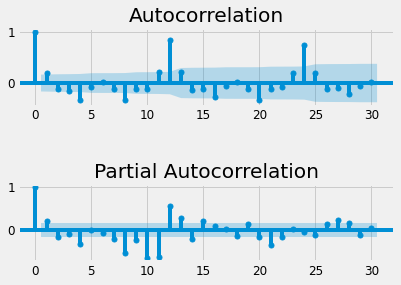

In [34]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts_log_diff, ax=pyplot.gca(),lags=30)
pyplot.subplots_adjust(hspace=1)
pyplot.subplot(212)
plot_pacf(ts_log_diff, ax=pyplot.gca(),lags=30)
pyplot.show()

### Interpretation of ACF and PACF plot

* If the PACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "under-differenced"--then consider adding an ARterm to the model. The lag at which the PACF cuts off is the indicated number of AR terms


* If the ACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "over-differenced"--then consider adding an MAterm to the model. The lag at which the ACF cuts off is the indicated number of MA terms


* It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge


* If there is a unit root in the AR part of the model--i.e., if the sum of the AR coefficients is almost exactly 1--you should reduce the number of AR terms by one and increase the order of differencing by one


* If there is a unit root in the MA part of the model--i.e., if the sum of the MA coefficients is almost exactly 1--you should reduce the number of MA terms by one and reduce the order of differencing by one.


**In the above plots of ACF and PACF, PACF is showing a sharp cutoff and ACF plot has positive correlation at lag 1 hence  we will build the AR (1) model**

### Autoregression (AR)
- The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.
- Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

In [35]:
## create test & train data set
from statsmodels.tsa.ar_model import AR
from random import random

train_size = int(len(ts_log_diff) * 0.7)
train, test = ts_log_diff[0:train_size], ts_log_diff[train_size:]

In [36]:
## fit AR model
model = AR(train, freq='MS')
model_fit = model.fit()

In [37]:
## get predictions
predictions = model_fit.predict(start= len(train), end=len(train)+len(test)-1,dynamic=False)

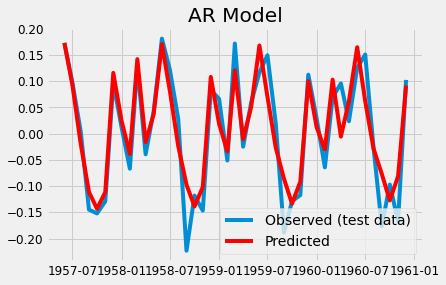

In [38]:
## visualize the test data & predictions

plt.plot(test, label='Observed (test data)')
plt.plot(predictions, color='red', label = 'Predicted')
plt.title('AR Model')
plt.legend()

In [39]:
## get evaluation metrics
evaluate_forecast(test, predictions)

,r2_score,mean_absolute_error,median_absolute_error,mse,mape,rmse
0,0.828604,0.03599,0.025568,0.002258,58.363508,0.04752


### Moving Average (MA)

- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at i'th instant and actual value. 

In [40]:
# fit MA model
from statsmodels.tsa.arima_model import ARMA

model = ARMA(train, order=(1, 0),freq='MS')
model_fit = model.fit(disp=False)

In [41]:
## get predictions
predictions = model_fit.predict(start= len(train), end=len(train)+len(test)-1,dynamic=False)

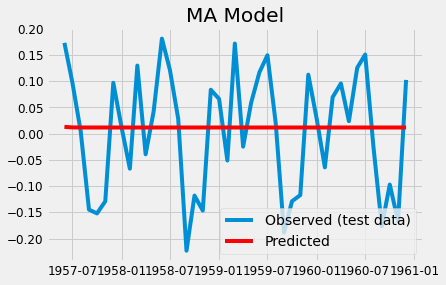

In [42]:
## visualize the test data & predictions

plt.plot(test, label='Observed (test data)')
plt.plot(predictions, color='red', label = 'Predicted')
plt.title('MA Model')
plt.legend()

In [43]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             passengers   No. Observations:                  100
Model:                     ARMA(1, 0)   Log Likelihood                  87.186
Method:                       css-mle   S.D. of innovations              0.101
Date:                Sat, 02 Oct 2021   AIC                           -168.372
Time:                        13:06:47   BIC                           -160.556
Sample:                    02-01-1949   HQIC                          -165.209
                         - 05-01-1957                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0116      0.012      0.990      0.322      -0.011       0.035
ar.L1.passengers     0.1393      0.099      1.413      0.158      -0.054       0.333
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            7.1771           +0.0000j            7.1771            0.0000
-----------------------------------------------------------------------------
"""

### Autoregressive Moving Average (ARMA)

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 


In [44]:
# fit ARMA model
model = ARMA(train, order=(2, 1),freq='MS')
model_fit = model.fit()

In [45]:
## get predictions
predictions = model_fit.predict(start= len(train), end=len(train)+len(test)-1,dynamic=False)

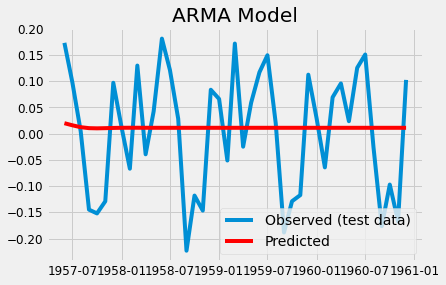

In [46]:
## visualize the test data & predictions

plt.plot(test, label='Observed (test data)')
plt.plot(predictions, color='red', label = 'Predicted')
plt.title('ARMA Model')
plt.legend()

In [47]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             passengers   No. Observations:                  100
Model:                     ARMA(2, 1)   Log Likelihood                 100.860
Method:                       css-mle   S.D. of innovations              0.087
Date:                Sat, 02 Oct 2021   AIC                           -191.721
Time:                        13:07:02   BIC                           -178.695
Sample:                    02-01-1949   HQIC                          -186.449
                         - 05-01-1957                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0110      0.001     17.083      0.000       0.010       0.012
ar.L1.passengers     0.9069      0.093      9.797      0.000       0.725       1.088
ar.L2.passengers    -0.3592      0.092     -3.902      0.000      -0.540      -0.179
ma.L1.passengers    -0.9999      0.027    -36.703      0.000      -1.053      -0.947
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2623           -1.0910j            1.6685           -0.1134
AR.2            1.2623           +1.0910j            1.6685            0.1134
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [48]:
evaluate_forecast(test, predictions)

,r2_score,mean_absolute_error,median_absolute_error,mse,mape,rmse
0,0.004278,0.098668,0.101222,0.013119,96.468171,0.114538


### Autoregressive Integrated Moving Average (ARIMA)
In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- __Number of Differences (d):__ d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 

<br>__Observations from EDA on the time series:__
- Non stationarity implies at least one level of differencing (d) is required in ARIMA
- [The next step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots](https://people.duke.edu/~rnau/411arim3.htm)

[Tuning ARIMA parameters](https://machinelearningmastery.com/tune-arima-parameters-python/)


Note: A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

In [49]:
## get train & test data
train_size = int(len(ts_log) * 0.7)
train, test = ts_log[0:train_size], ts_log[train_size:]

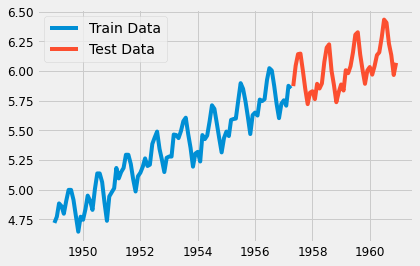

In [50]:
#plotting the data
plt.plot(train, label='Train Data')
plt.plot(test, label = 'Test Data')
plt.legend()

In [51]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA

# fit model
model = ARIMA(train, order=(1, 1, 2),freq='MS')
model_fit = model.fit(disp=1)

In [52]:
## get predictions
predictions = model_fit.predict(start= len(train), end=len(train)+len(test)-1,dynamic=False,typ='levels')

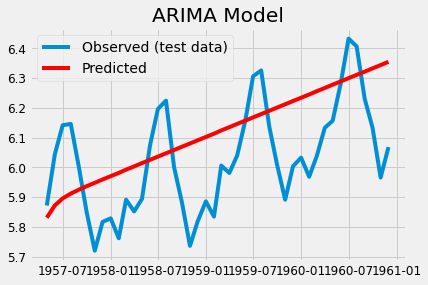

In [53]:
## visualize the test data & predictions
plt.plot(test, label='Observed (test data)')
plt.plot(predictions, color='red', label = 'Predicted')
plt.title('ARIMA Model')
plt.legend()

In [54]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.passengers   No. Observations:                   99
Model:                 ARIMA(1, 1, 2)   Log Likelihood                  98.568
Method:                       css-mle   S.D. of innovations              0.088
Date:                Sat, 02 Oct 2021   AIC                           -187.136
Time:                        13:07:54   BIC                           -174.160
Sample:                    02-01-1949   HQIC                          -181.886
                         - 04-01-1957                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0110      0.001     14.365      0.000       0.009       0.012
ar.L1.D.passengers     0.4122      0.135      3.053      0.002       0.148       0.677
ma.L1.D.passengers    -0.4765      0.146     -3.262      0.001      -0.763      -0.190
ma.L2.D.passengers    -0.5235      0.144     -3.628      0.000      -0.806      -0.241
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.4262           +0.0000j            2.4262            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.9104           +0.0000j            1.9104            0.5000
-----------------------------------------------------------------------------
"""

In [55]:
evaluate_forecast(test, predictions)

,r2_score,mean_absolute_error,median_absolute_error,mse,mape,rmse
0,-0.135363,0.165741,0.152719,0.03499,2.767526,0.187056


#### Auto ARIMA

Auto-ARIMA can be used to run different models with varying parameters of p,d, q & and choose the best parameters based on the lowest AIC/BIC scores.

* This eliminates the need for checking parameter values based on ACF, PACF plots
* This is helpful when running a lot of models at scale, as manual check of each model is not possible

In [56]:
#building the model
# from pyramid.arima import auto_arima 
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-184.633, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-165.683, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-165.650, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-166.640, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-166.459, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-186.924, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-187.467, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-165.514, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-174.055, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-167.161, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-176.055, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-188.941, Time=0.22 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-

In [57]:
forecast= model.predict(n_periods=test.shape[0],return_conf_int=False)
forecast = pd.Series(forecast,index = test.index)

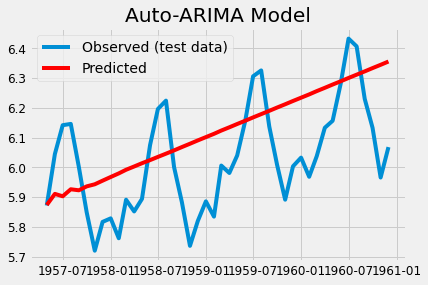

In [58]:
plt.plot(test, label='Observed (test data)')
plt.plot(forecast, color='red', label = 'Predicted')
plt.title('Auto-ARIMA Model')
plt.legend()

In [59]:
evaluate_forecast(test, forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,mape,rmse
0,-0.115234,0.163245,0.149021,0.03437,2.725606,0.18539


#### Seasonal Autoregressive Integrated Moving-Average (SARIMA)
Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

__Trend Elements:__

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

__Seasonal Elements:__

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.

__SARIMA notation:__
SARIMA(p,d,q)(P,D,Q,m)

In [60]:
 #SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit model
model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 3),freq='MS')
model_fit = model.fit(disp=False,maxiter=200)

C:\Users\carry\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [61]:
## get predictions
start_index = test.index.min()
end_index = test.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

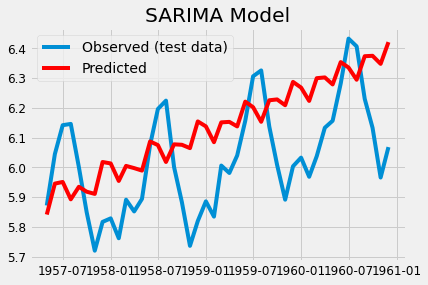

In [62]:
## visualize actual & predicted values
plt.plot(test, label='Observed (test data)')
plt.plot(predictions, color='red', label = 'Predicted')
plt.title('SARIMA Model')
plt.legend()

In [63]:
# get evaluation metrics
evaluate_forecast(test, predictions)

,r2_score,mean_absolute_error,median_absolute_error,mse,mape,rmse
0,-0.260478,0.17535,0.172209,0.038846,2.925283,0.197093


#### Auto - SARIMA


Similar to Auto-ARIMA, the Auto-SARIMA runs different models with varying parameters of p,d, q & seasonal order parameters of P, D, Q & m, and choose the best parameters based on the lowest AIC/BIC scores.

This eliminates the need for checking parameter values based on ACF, PACF plots

In [64]:
#fit the model
#from pyramid.arima import auto_arima

model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=6, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=-165.683, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=-165.539, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=-165.245, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=-166.459, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[6] intercept   : AIC=-164.730, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[6] intercept   : AIC=-164.082, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[6] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[6] intercept   : AIC=-165.650, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=-166.640, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[6] intercept   : AIC=-166.205, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[6] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[6] intercept   : AIC=-169.537, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[6] intercept   : AIC=-168.982, Time=0.11 sec
 ARIMA(1,1,1)(0,0,1)[6] intercept   : AIC=-168.0

In [65]:
## get predictions
forecast= model.predict(n_periods=test.shape[0],return_conf_int=False)
forecast = pd.Series(forecast,index = test.index)

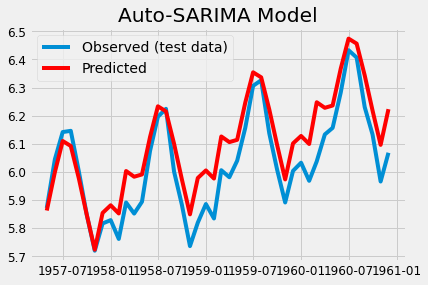

In [66]:
plt.plot(test, label='Observed (test data)')
plt.plot(forecast, color='red', label = 'Predicted')
plt.title('Auto-SARIMA Model')
plt.legend()

In [69]:
evaluate_forecast(test, forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,mape,rmse
0,0.714382,0.081706,0.086453,0.008802,1.361644,0.09382


#### Tuned SARIMA

While Auto-SARIMA works best to check different parameters & choose the best model, there might be a need to -
* Specify an upper limit to parameters to avoid higher p & q values
* Choose optimal parameters from a possible manual choice of parameters

In these scenarios, SARIMA parameters can be tuned using grid search, to choose the best parameters from a given subset of values

In [70]:
## setting range for parameters
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 0, 1) x (0, 1, 0, 6)
SARIMAX: (0, 1, 0) x (0, 1, 1, 6)
SARIMAX: (0, 1, 0) x (1, 0, 0, 6)


In [73]:
## tuning to find the model with least AIC score
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,freq='MS')
            
            results = mod.fit(maxiter=500)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 6)12 - AIC:614.8524133160895
ARIMA(0, 0, 0)x(0, 0, 1, 6)12 - AIC:475.1975567069759
ARIMA(0, 0, 0)x(0, 1, 0, 6)12 - AIC:-19.334621271415642
ARIMA(0, 0, 0)x(0, 1, 1, 6)12 - AIC:-41.15361686089656
ARIMA(0, 0, 0)x(1, 0, 0, 6)12 - AIC:-23.094721036118237
ARIMA(0, 0, 0)x(1, 0, 1, 6)12 - AIC:-115.95955729711882
ARIMA(0, 0, 0)x(1, 1, 0, 6)12 - AIC:-92.65916601575915
ARIMA(0, 0, 0)x(1, 1, 1, 6)12 - AIC:-161.1065570743382
ARIMA(0, 0, 1)x(0, 0, 0, 6)12 - AIC:480.66000798425387
ARIMA(0, 0, 1)x(0, 0, 1, 6)12 - AIC:349.8658765150938
ARIMA(0, 0, 1)x(0, 1, 0, 6)12 - AIC:-97.51289629324359
ARIMA(0, 0, 1)x(0, 1, 1, 6)12 - AIC:-112.23986399317424
ARIMA(0, 0, 1)x(1, 0, 0, 6)12 - AIC:-99.85732293749923
ARIMA(0, 0, 1)x(1, 0, 1, 6)12 - AIC:-175.15000940011387
ARIMA(0, 0, 1)x(1, 1, 0, 6)12 - AIC:-162.14525343257066
ARIMA(0, 0, 1)x(1, 1, 1, 6)12 - AIC:-205.87302391114534
ARIMA(0, 1, 0)x(0, 0, 0, 6)12 - AIC:-164.015527937591
ARIMA(0, 1, 0)x(0, 0, 1, 6)12 - AIC:-149.75145911770935
ARIMA(

In [74]:
min_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         passengers   No. Observations:                  100
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 6)   Log Likelihood                 144.146
Date:                            Sat, 02 Oct 2021   AIC                           -282.291
Time:                                    13:10:12   BIC                           -274.893
Sample:                                01-01-1949   HQIC                          -279.312
                                     - 04-01-1957                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3868      0.091     -4.269      0.000      -0.564      -0.209
ar.S.L6       -0.9829      0.034    -29.088      0.000      -1.049      -0.917
sigma2         0.0021      0.000      7.085      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.05
Prob(Q):                              0.88   Prob(JB):                         0.36
Heteroskedasticity (H):               0.23   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [75]:
## get predictions
start_index = test.index.min()
end_index = test.index.max()

#Predictions
predictions = min_aic_model.predict(start=start_index,end=end_index, dynamic=False)

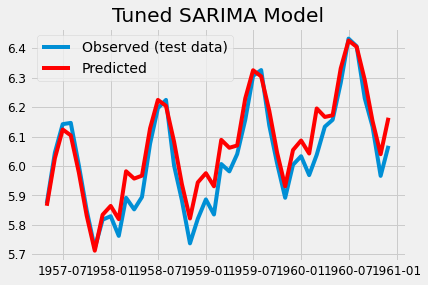

In [76]:
## visualize actual & predicted values
plt.plot(test, label='Observed (test data)')
plt.plot(predictions, color='red', label = 'Predicted')
plt.title('Tuned SARIMA Model')
plt.legend()

In [77]:
evaluate_forecast(test, predictions)

,r2_score,mean_absolute_error,median_absolute_error,mse,mape,rmse
0,0.87492,0.051527,0.049743,0.003855,0.861579,0.062087


__Model diagnostics:__
- Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. 
- If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

The model diagnostic suggests that the model residual is normally distributed based on the following:

- In the top right plot, the red KDE line follows closely with the N(0,1) line. Where, N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation of 1. This is a good indication that the residuals are normally distributed. 
- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution. Again, this is a strong indication that the residuals are normally distributed.
- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. 
- This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

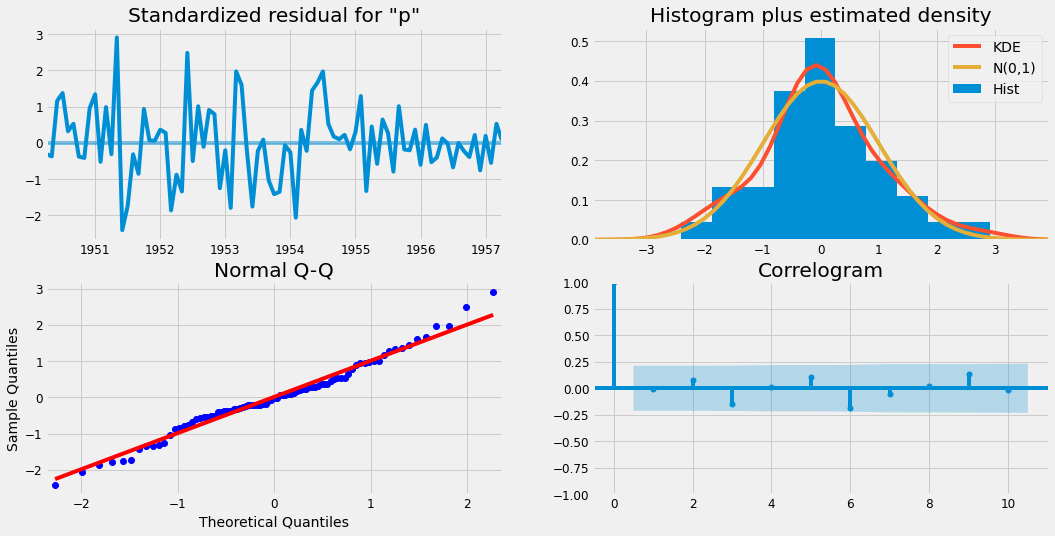

In [78]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### ARIMAX and SARIMAX
- The implementation is called ARIMAX/SARIMAX instead of SARIMA because the “X” addition to the method name means that the implementation also supports exogenous variables.
- Exogenous variables are optional can be specified via the “exog” argument.
 - model = SARIMAX(data, exog=other_data, ...)
- Examples of exogenous variables: Population, holidays, number of airline companies, major events

#### ARIMAX

In [81]:
## load sales data for a store
sales_data = pd.read_csv('sales_data.csv',parse_dates=['date'],index_col='date')
sales_data.head()

,sales
date,
2013-01-01,13.0
2013-01-02,11.0
2013-01-03,14.0
2013-01-04,13.0
2013-01-05,10.0


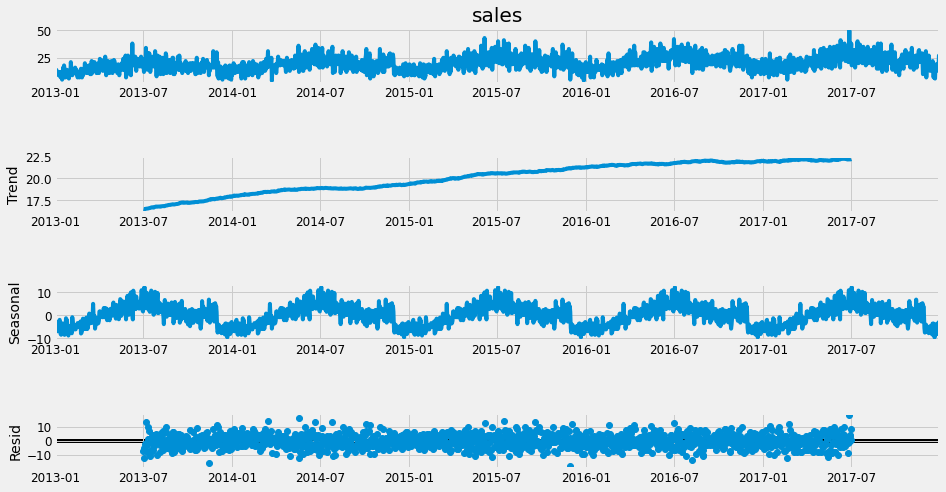

In [82]:
## visualize sales data, along with its trend & seasonality
res = sm.tsa.seasonal_decompose(sales_data.sales.dropna(),freq=365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

Clearly, this data has a growing trend

In [83]:
###month one hot encoding
sales_data['month'] = sales_data.index.month
month_dummies = pd.get_dummies(sales_data['month'])
month_dummies.columns = ['month-'+ str(m) for m in range(1,13)]
# sales_data = pd.concat([sales_data, month_dummies], axis=1, join_axes=[sales_data.index]).drop(['month'],axis=1)
# sales_data.head(40)

In [84]:
sales_data1 = pd.concat([sales_data, month_dummies], axis=1)
sales_data1 = sales_data1.reindex(sales_data.index)
sales_data1 = sales_data1[['sales'] + month_dummies.columns.tolist()]
sales_data1.head(5)

,sales,month-1,month-2,month-3,month-4,month-5,month-6,month-7,month-8,month-9,month-10,month-11,month-12
date,,,,,,,,,,,,,
2013-01-01,13.0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-02,11.0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-03,14.0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-04,13.0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-05,10.0,1,0,0,0,0,0,0,0,0,0,0,0


In [85]:
sales_data_bkup = sales_data.copy()

In [86]:
sales_data = sales_data1

In [87]:
#dayofweek one hot encoding
sales_data['dayofweek'] = sales_data.index.weekday
week_dummies = pd.get_dummies(sales_data['dayofweek'])
week_dummies.columns = ['dayofweek-'+ str(w) for w in range(0,7)]


In [88]:
sales_data = sales_data.drop(['dayofweek'],axis=1)
sales_data = pd.concat([sales_data, week_dummies], axis=1)
sel_col = sales_data.columns.tolist() + week_dummies.columns.to_list()
sales_data = sales_data[sel_col]
sales_data.head()


,sales,month-1,month-2,month-3,month-4,month-5,month-6,month-7,month-8,month-9,month-10,month-11,month-12,dayofweek-0,dayofweek-1,dayofweek-2,dayofweek-3,dayofweek-4,dayofweek-5,dayofweek-6,dayofweek-0,dayofweek-1,dayofweek-2,dayofweek-3,dayofweek-4,dayofweek-5,dayofweek-6
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2013-01-02,11.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2013-01-03,14.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2013-01-04,13.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2013-01-05,10.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [89]:
#Satday,Sunday
sales_data['weekend'] = (sales_data.index.dayofweek>4).astype(int)
sales_data.head()

,sales,month-1,month-2,month-3,month-4,month-5,month-6,month-7,month-8,month-9,month-10,month-11,month-12,dayofweek-0,dayofweek-1,dayofweek-2,dayofweek-3,dayofweek-4,dayofweek-5,dayofweek-6,dayofweek-0,dayofweek-1,dayofweek-2,dayofweek-3,dayofweek-4,dayofweek-5,dayofweek-6,weekend
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2013-01-02,11.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2013-01-03,14.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2013-01-04,13.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2013-01-05,10.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1


In [90]:
# Create test & train data

tr_start,tr_end = '2015-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
train = sales_data['sales'][tr_start:tr_end].dropna()
test = sales_data['sales'][te_start:te_end].dropna()
exog_train = sales_data.drop(['sales'],axis = 1)[tr_start:tr_end].dropna()
exog_test = sales_data.drop(['sales'],axis = 1)[te_start:te_end].dropna()

In [91]:
## run ARIMAX model with exog data

arimax = sm.tsa.statespace.SARIMAX(train,seasonal_order=(0,0,0,0),exog = exog_train,freq='D',
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1004
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -2962.766
Date:                Sat, 02 Oct 2021   AIC                           5983.533
Time:                        13:11:18   BIC                           6125.944
Sample:                    01-01-2015   HQIC                          6037.651
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
month-1        -2.6963      0.557     -4.839      0.000      -3.788      -1.604
month-2        -1.4941      0.522     -2.860      0.004      -2.518      -0.470
month-3         1.0982      0.503      2.185      0.029       0.113       2.083
month-4         5.1038      0.522      9.769      0.000       4.080       6.128
month-5         7.1107      0.448     15.858      0.000       6.232       7.990
month-6         9.3488      0.439     21.315      0.000       8.489      10.208
month-7        10.7717      0.440     24.465      0.000       9.909      11.635
month-8         6.7694      0.452     14.969      0.000       5.883       7.656
month-9         6.2947      0.472     13.335      0.000       5.370       7.220
month-10        4.3429      0.580      7.491      0.000       3.207       5.479
month-11        5.2227      0.597      8.754      0.000       4.053       6.392
month-12       -1.8559      0.600     -3.093      0.002      -3.032      -0.680
dayofweek-0     6.2142      0.211     29.437      0.000       5.800       6.628
dayofweek-1     7.7739      0.214     36.355      0.000       7.355       8.193
dayofweek-2     8.0171      0.195     41.107      0.000       7.635       8.399
dayofweek-3     8.3398      0.199     41.881      0.000       7.950       8.730
dayofweek-4     9.2388      0.171     54.051      0.000       8.904       9.574
dayofweek-5     5.0554      0.143     35.411      0.000       4.776       5.335
dayofweek-6     5.3773      0.153     35.254      0.000       5.078       5.676
dayofweek-0     6.2142      0.211     29.437      0.000       5.800       6.628
dayofweek-1     7.7739      0.214     36.355      0.000       7.355       8.193
dayofweek-2     8.0171      0.195     41.107      0.000       7.635       8.399
dayofweek-3     8.3398      0.199     41.881      0.000       7.950       8.730
dayofweek-4     9.2388      0.171     54.051      0.000       8.904       9.574
dayofweek-5     5.0554      0.143     35.411      0.000       4.776       5.335
dayofweek-6     5.3773      0.153     35.254      0.000       5.078       5.676
weekend        10.4327      0.131     79.742      0.000      10.176      10.689
ar.L1           0.0139      0.034      0.414      0.679      -0.052       0.080
sigma2         21.5402      0.902     23.882      0.000      19.772      23.308
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                27.62
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.28
Prob(H) (two-sided):                  0.89   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.74e+

In [92]:
## get evaluation metrics
pred_arimax = arimax.predict(tr_end,te_end,exog = exog_test)[1:]
evaluate_forecast(test, pred_arimax)

,r2_score,mean_absolute_error,median_absolute_error,mse,mape,rmse
0,0.372676,3.80482,3.142705,21.275888,22.048759,4.612579


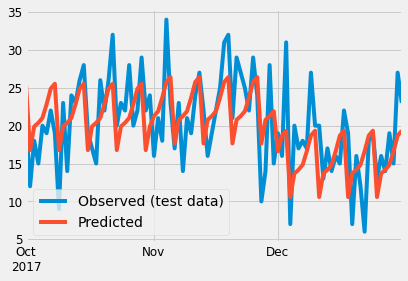

In [93]:
## plot test vs predicted values
pd.DataFrame({'Observed (test data)':test,'Predicted':pred_arimax}).plot();plt.show()

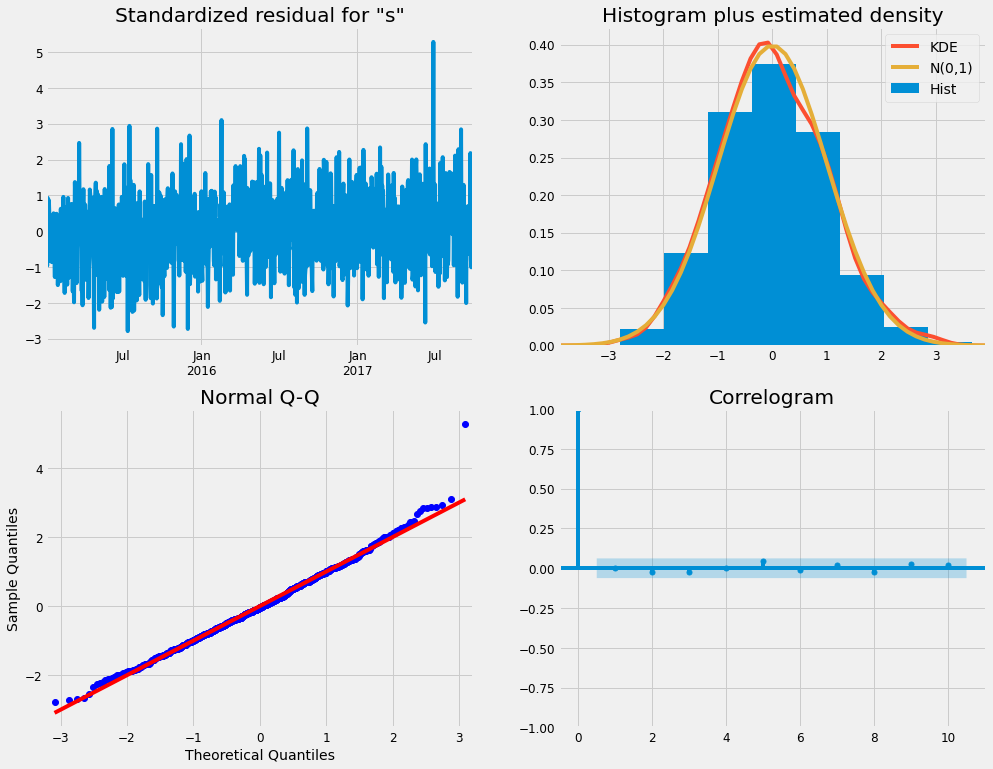

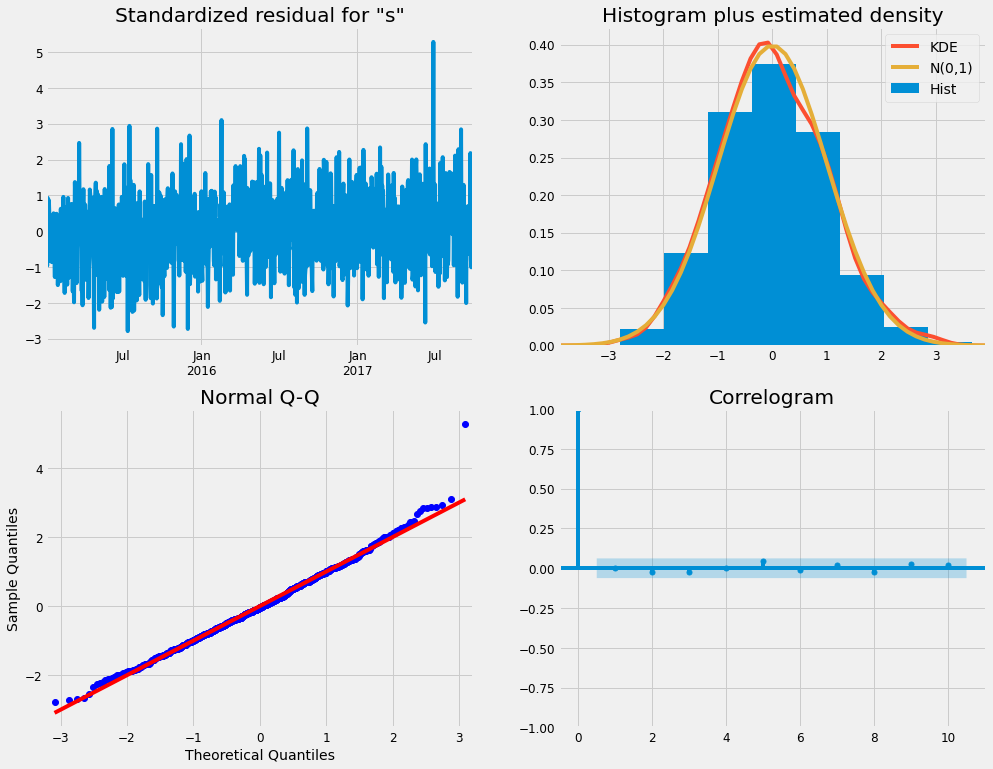

In [94]:
arimax.plot_diagnostics(figsize=(15, 12))

#### SARIMAX

In [95]:
## selecting model parameters - p & q for seasonal part

res = sm.tsa.seasonal_decompose(train.dropna(),freq=365)
resDiff = sm.tsa.arma_order_select_ic(res.seasonal, max_ar=3, max_ma=3, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (3, 3) is the best.


In [96]:
## run SARIMAX model with seasonal order
sarimax = sm.tsa.statespace.SARIMAX(train,exog = exog_train,seasonal_order = (3, 1, 3, 1),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D',validate_specification = False).fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                     sales   No. Observations:                 1004
Model:             SARIMAX(1, 0, 0)x(3, 1, [1, 2, 3], 1)   Log Likelihood            -2004891.761
Date:                                   Sat, 02 Oct 2021   AIC                        4009853.521
Time:                                           13:11:36   BIC                        4010025.257
Sample:                                       01-01-2015   HQIC                       4009918.796
                                            - 09-30-2017                                         
Covariance Type:                                     opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
month-1        -2.4772   1.03e-27   -2.4e+27      0.000      -2.477      -2.477
month-2        -1.9102         -0        inf      0.000      -1.910      -1.910
month-3        -5.3414        nan        nan        nan         nan         nan
month-4         3.4354        nan        nan        nan         nan         nan
month-5        -4.2335   1.02e-33  -4.14e+33      0.000      -4.234      -4.234
month-6         0.9384   5.63e-34   1.67e+33      0.000       0.938       0.938
month-7         4.3884   7.73e-34   5.68e+33      0.000       4.388       4.388
month-8        -0.4903   7.34e-34  -6.68e+32      0.000      -0.490      -0.490
month-9         3.2454    4.8e-34   6.77e+33      0.000       3.245       3.245
month-10        6.2789   1.51e-33   4.16e+33      0.000       6.279       6.279
month-11       -0.6890    1.8e-33  -3.84e+32      0.000      -0.689      -0.689
month-12       -3.2367   4.99e-32  -6.49e+31      0.000      -3.237      -3.237
dayofweek-0  1.315e+13   2.26e-21   5.81e+33      0.000    1.31e+13    1.31e+13
dayofweek-1   1.53e+13   3.39e-21   4.51e+33      0.000    1.53e+13    1.53e+13
dayofweek-2  1.131e+13   3.05e-21    3.7e+33      0.000    1.13e+13    1.13e+13
dayofweek-3  1.338e+13   3.36e-21   3.98e+33      0.000    1.34e+13    1.34e+13
dayofweek-4  1.644e+13   2.68e-21   6.14e+33      0.000    1.64e+13    1.64e+13
dayofweek-5  1.274e+14   2.98e-21   4.28e+34      0.000    1.27e+14    1.27e+14
dayofweek-6  2.857e+13    2.8e-21   1.02e+34      0.000    2.86e+13    2.86e+13
dayofweek-0   1.24e+13   2.26e-21   5.48e+33      0.000    1.24e+13    1.24e+13
dayofweek-1  1.024e+13   3.39e-21   3.02e+33      0.000    1.02e+13    1.02e+13
dayofweek-2  1.424e+13   3.05e-21   4.66e+33      0.000    1.42e+13    1.42e+13
dayofweek-3  1.217e+13   3.36e-21   3.62e+33      0.000    1.22e+13    1.22e+13
dayofweek-4  9.107e+12   2.68e-21    3.4e+33      0.000    9.11e+12    9.11e+12
dayofweek-5 -3.025e+13   2.98e-21  -1.02e+34      0.000   -3.03e+13   -3.03e+13
dayofweek-6  6.861e+13    2.8e-21   2.45e+34      0.000    6.86e+13    6.86e+13
weekend     -7.164e+13   3.85e-21  -1.86e+34      0.000   -7.16e+13   -7.16e+13
ar.L1          -0.5734   5.65e-17  -1.01e+16      0.000      -0.573      -0.573
ar.S.L1        -0.8181   2.51e-20  -3.26e+19      0.000      -0.818      -0.818
ar.S.L2        -0.4033    2.8e-20  -1.44e+19      0.000      -0.403      -0.403
ar.S.L3        -1.0988   2.95e-17  -3.72e+16      0.000      -1.099      -1.099
ma.S.L1     -4.999e-06   3.75e-12  -1.33e+06      0.000      -5e-06      -5e-06
ma.S.L2     -4.994e-06   3.75e-12  -1.33e+06      0.000   -4.99e-06   -4.99e-06
ma.S.L3     -5.009e-06   3.75e-12  -1.34e+06      0.000   -5.01e-06   -5.01e-06
sigma2         32.5097   4.99e-19   6.52e+19      0.000      32.510      32.510
==============================

In [97]:
## get evaluation metrics
pred_sarimax = sarimax.predict(tr_end,te_end,exog = exog_test)[1:]
evaluate_forecast(test, pred_sarimax)

,r2_score,mean_absolute_error,median_absolute_error,mse,mape,rmse
0,-1.730601e+13,7.974996e+06,14154.982422,5.869384e+14,4.798881e+07,2.422681e+07


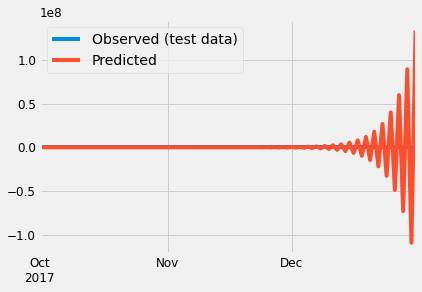

In [98]:
pd.DataFrame({'Observed (test data)':test,'Predicted':pred_sarimax}).plot();plt.show()

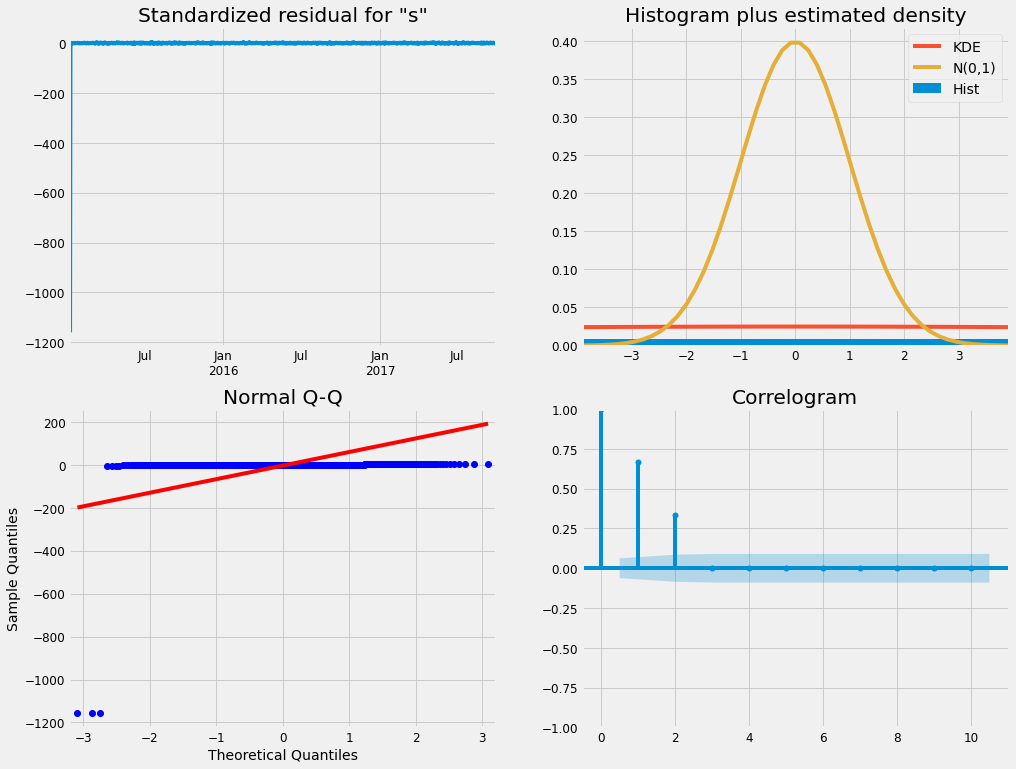

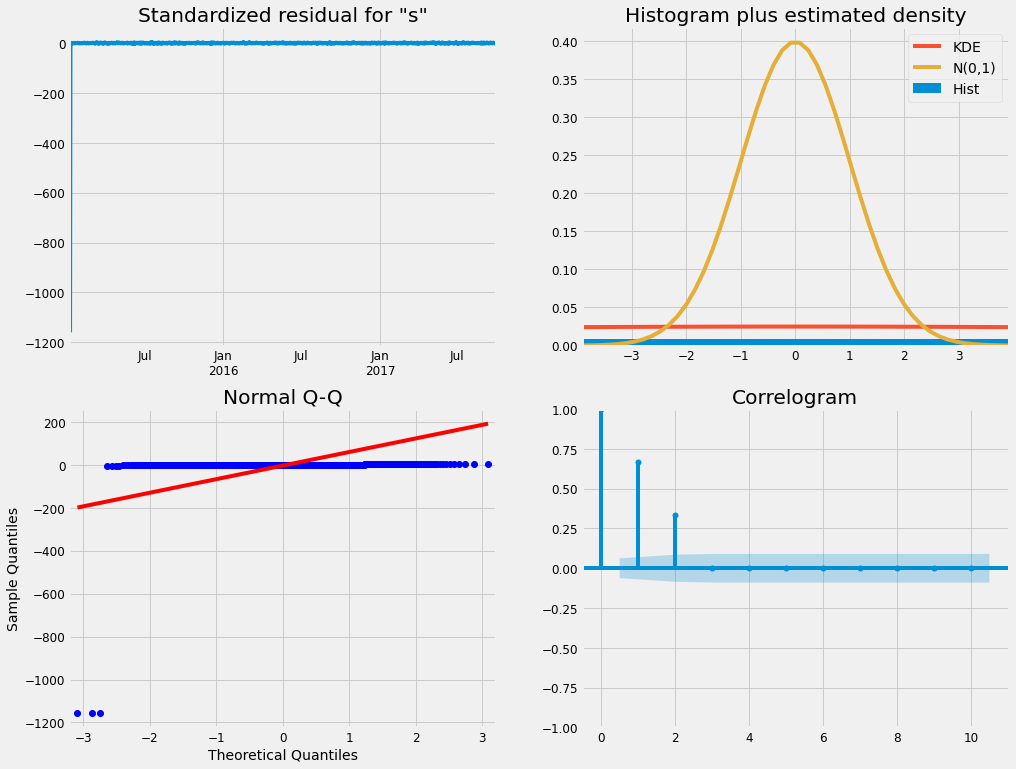

In [99]:
sarimax.plot_diagnostics(figsize=(15, 12))